In [5]:
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
import datetime as dt
pd.options.display.max_colwidth = 10000
pd.options.display.max_rows = 10000

def append_row(accounts_df, date_str, col_name, value, description):
    row_idx = len(accounts_df)
    date_obj = dt.datetime.strptime(date_str,"%Y-%m-%d 00:00:00")
    accounts_joined.loc[row_idx, "Date"] = date_obj
    accounts_joined.loc[row_idx, "Description"] = description
    accounts_joined.loc[row_idx, col_name] = value

all_payments = pd.read_csv("/Users/johnclark/Documents/Finances/All_Payment_Methods020122.csv")
end_of_year = pd.read_csv("/Users/johnclark/Documents/Finances/Year End All Payment Methods020122.csv",parse_dates=[2], header=0)
end_of_year["Amount_value"] = end_of_year["Amount"].apply(lambda x: float(x[1:].replace(",","")) if x.startswith("$") else -float(x[2:].replace(",","")) if x.startswith("-$") else x)

no_credit_card = end_of_year[end_of_year["Payee"] != "WELLS FARGO CREDIT CARD"]
no_wells_credit_rec_trans = end_of_year[(end_of_year["Payee"] != "WELLS FARGO CREDIT CARD") & (~end_of_year["Description"].str.startswith("RECURRING TRANSFER")) \
                                        & (~end_of_year["Description"].str.startswith("ONLINE TRANSFER TO CLARK J SAVINGS XXXXXX5751")) \
                                        & (~end_of_year["Description"].str.startswith("ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9873"))]

years = [2022,2021] #[2020, 2021, 2022]
accounts_joined = pd.DataFrame([], columns=["Date","Amount","Unk","CheckNum","Description"])
for year in years:
    utility_check = pd.read_csv("/Users/johnclark/Documents/Finances/Utility{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    utility_check["account_name"] = "utility"
    umbrella_check = pd.read_csv("/Users/johnclark/Documents/Finances/Umbrella{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    umbrella_check["account_name"] = "umbrella"
    savings_check = pd.read_csv("/Users/johnclark/Documents/Finances/Savings{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    savings_check["account_name"] = "savings"
    primary_check = pd.read_csv("/Users/johnclark/Documents/Finances/Primary{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    primary_check["account_name"] = "primary"
    platinum_card = pd.read_csv("/Users/johnclark/Documents/Finances/PlatinumCard{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    platinum_card["account_name"] = "platinum"
    cashwise_card = pd.read_csv("/Users/johnclark/Documents/Finances/CashWiseCard{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
    cashwise_card["account_name"] = "cashwise"

    accounts_joined = accounts_joined.append(utility_check)
    accounts_joined = accounts_joined.append(umbrella_check)
    accounts_joined = accounts_joined.append(savings_check)
    accounts_joined = accounts_joined.append(primary_check)
    # accounts_joined = accounts_joined.append(platinum_card)
    # accounts_joined = accounts_joined.append(cashwise_card)

accounts_joined.reset_index(inplace=True, drop=True)

#assert len(accounts_joined) == len(utility_check) + len(umbrella_check) + len(savings_check) + len(primary_check)# + len(platinum_card) + len(cashwise_card)

accounts_joined["spending"] = accounts_joined["Amount"].apply(lambda x: x if x<0.0 else 0.0)
accounts_joined["income"] = accounts_joined["Amount"].apply(lambda x: x if x>0.0 else 0.0)

exclude_desc = {"FID BKG SVC LLC MONEYLINE 210402 X49800767 O0TLA JOHN P CLARK","RECURRING TRANSFER TO CLARK",
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX7135", 
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9865", 
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9873", 
                "ONLINE TRANSFER TO CLARK J SAVINGS XXXXXX5751", 
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX7135",
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX9865",
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX9873",
                "ONLINE TRANSFER FROM CLARK J SAVINGS XXXXXX5751",
                "ONLINE TRANSFER FROM CLARK J",
                "ONLINE TRANSFER TO CLARK J"}
tithe_desc_starts = {"RURAL INDIA MINI", "BILL PAY Rural India Ministries ", "BILL PAY Church of the Open Door",
                     "CHECK # 136","BUSINESS TO BUSINESS ACH www.gracepres.co", 
                     "CHECK # 198",
                     "BILL PAY Church of the Resurrection",
                     "Flagstaff Christ", "FLAGSTAFF CHRIST",
                     "Mount Calvary"}
tax_desc_starts = {"CHECK # 132",
                   "CHECK # 131",
                   "FRANCHISE TAX BD CASTTAXRFD",
                   "IRS USATAXPYMT"}
shoffice_starts = {"CHECK # 129","DEPOSITED OR CASHED CHECK # 128","CASHED CHECK # 127"}
dirtbike_starts = {"CHECK # 195","CHECK # 196"}

accounts_joined["chase"] = accounts_joined.apply(lambda r: r["Amount"] if r["Description"].startswith("CHASE") else 0.0, raw=False, axis=1)
accounts_joined["tithe"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tithe_desc_starts if r["Description"].startswith(td)]) > 0  else 0.0, raw=False, axis=1)
accounts_joined["taxes"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tax_desc_starts if r["Description"].startswith(td)]) > 0  else 0.0, raw=False, axis=1)
accounts_joined["taxes_spend"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tax_desc_starts if r["Description"].startswith(td)]) > 0 and r["Amount"] < 0.0  else 0.0, raw=False, axis=1)
accounts_joined["shoffice"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in shoffice_starts if r["Description"].startswith(td)]) > 0 and r["Amount"] < 0.0  else 0.0, raw=False, axis=1)
accounts_joined["dirtbikes"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in dirtbike_starts if r["Description"].startswith(td)]) > 0 and r["Amount"] < 0.0  else 0.0, raw=False, axis=1)
accounts_joined["apple"] = accounts_joined.apply(lambda r: r["Amount"] if r["Description"].startswith("APPLE INC. PAYROLL") else 0.0, raw=False, axis=1)

accounts_joined["base_spend_adjustment"] = 0.0
if 2022 in years:
    append_row(accounts_joined, "2022-05-09 00:00:00", "base_spend_adjustment", -692.20, description="Sig 365X") #
    append_row(accounts_joined, "2022-05-09 00:00:00", "base_spend_adjustment", -2838.70, description="Stacato P") #

    append_row(accounts_joined, "2022-02-27 00:00:00", "base_spend_adjustment", -2573.72, description="Avis mistake charge") #

    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #
    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #
    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #
    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #
    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #
    append_row(accounts_joined, "2022-02-15 00:00:00", "base_spend_adjustment", -749.50, description="Alaska air") #

    append_row(accounts_joined, "2022-02-10 00:00:00", "base_spend_adjustment", -3458.58, description="Alaska turo car") # 
    append_row(accounts_joined, "2022-02-05 00:00:00", "base_spend_adjustment", -5560.00, description="Alaska royal star train") #

    append_row(accounts_joined, "2022-02-04 00:00:00", "base_spend_adjustment", -477.18, description="Alaska Grand Denali Lodge") #
    append_row(accounts_joined, "2022-02-04 00:00:00", "base_spend_adjustment", -452.93, description="Alaska Grand Denali Lodge") #
    append_row(accounts_joined, "2022-02-04 00:00:00", "base_spend_adjustment", -460.93, description="Alaska Grand Denali Lodge") #

    append_row(accounts_joined, "2022-01-08 00:00:00", "base_spend_adjustment", -364.62, description="Sportsmans pelican case") #
if 2021 in years:
    append_row(accounts_joined, "2021-12-20 00:00:00", "base_spend_adjustment", -309.96, description="Southwest for Tara") #

    append_row(accounts_joined, "2021-12-17 00:00:00", "base_spend_adjustment", -869.16, description="Suppressor") #
    append_row(accounts_joined, "2021-12-17 00:00:00", "base_spend_adjustment", -2117.98, description="Herman miller chair") #

    append_row(accounts_joined, "2021-11-26 00:00:00", "base_spend_adjustment", -375.47, description="Black Barts dinner") #
    append_row(accounts_joined, "2021-11-08 00:00:00", "base_spend_adjustment", -107.99, description="Push to talk") #
    append_row(accounts_joined, "2021-10-10 00:00:00", "base_spend_adjustment", -687.54, description="Anniversary El Quoquistador") #
    append_row(accounts_joined, "2021-09-29 00:00:00", "base_spend_adjustment", -1916.00, description="10 yr Anniversary earings") #

    append_row(accounts_joined, "2021-08-25 00:00:00", "base_spend_adjustment", -403.17, description="Moms Iphone") #
    append_row(accounts_joined, "2021-08-25 00:00:00", "base_spend_adjustment", -2240.27, description="new Carpet final payment") #

    append_row(accounts_joined, "2021-08-06 00:00:00", "base_spend_adjustment", -500.38, description="Watermans dinner for Tara and Mikes anniversary") #
    append_row(accounts_joined, "2021-07-31 00:00:00", "base_spend_adjustment", -653.99, description="Papas ipad") #
    append_row(accounts_joined, "2021-07-30 00:00:00", "base_spend_adjustment", -2619.25, description="Hannahs new laptop") #
    append_row(accounts_joined, "2021-07-13 00:00:00", "base_spend_adjustment", -580.04, description="Sportsmans Hannahs scope") #
    append_row(accounts_joined, "2021-07-11 00:00:00", "base_spend_adjustment", -952.03, description="Sportsmans Hannahs gun") #
    append_row(accounts_joined, "2021-07-08 00:00:00", "base_spend_adjustment", -2072.00, description="New carpet") #
    append_row(accounts_joined, "2021-06-24 00:00:00", "base_spend_adjustment", -378.59, description="El conquist") #
    append_row(accounts_joined, "2021-06-20 00:00:00", "base_spend_adjustment", -250.00, description="Princess cruise") #

    append_row(accounts_joined, "2021-06-18 00:00:00", "base_spend_adjustment", -375.00, description="Princess cruise") #
    append_row(accounts_joined, "2021-06-18 00:00:00", "base_spend_adjustment", -500.00, description="Princess cruise") #
    append_row(accounts_joined, "2021-06-18 00:00:00", "base_spend_adjustment", -250.00, description="Princess cruise") #

    append_row(accounts_joined, "2021-03-29 00:00:00", "base_spend_adjustment", -880.00, description="hunting rifle") #

    append_row(accounts_joined, "2021-02-23 00:00:00", "base_spend_adjustment", -1148.49, description="Dirt bike repair") #
    append_row(accounts_joined, "2021-02-23 00:00:00", "base_spend_adjustment", -985.94, description="Dirt bike repair") #

    append_row(accounts_joined, "2021-02-05 00:00:00", "base_spend_adjustment", -1182.10, description="Shoffice charge on cashwise") #
    append_row(accounts_joined, "2021-02-05 00:00:00", "base_spend_adjustment", -46.25, description="Shoffice charge on cashwise") #
    append_row(accounts_joined, "2021-02-05 00:00:00", "base_spend_adjustment", -231.14, description="Shoffice charge on cashwise") #
    append_row(accounts_joined, "2021-02-05 00:00:00", "base_spend_adjustment", -61.71, description="Shoffice charge on cashwise") #
    append_row(accounts_joined, "2021-02-05 00:00:00", "base_spend_adjustment", -60.97, description="Shoffice charge on cashwise") #

na_maps = {col_name:0.0 for col_name in accounts_joined.columns}
na_maps["Description"] = ""
accounts_joined.fillna(na_maps, inplace=True)


accounts_joined["filtered_amount"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)
accounts_joined["filtered_income"] = accounts_joined.apply(lambda r: r["Amount"] if r["Amount"]>0.0 and len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)

accounts_joined["full_spending"] = accounts_joined.apply(lambda r: r["Amount"] if r["Amount"]<0.0 and len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)
accounts_joined["full_spending"] = accounts_joined["full_spending"] - accounts_joined["taxes_spend"]

accounts_joined["base_spending"] = accounts_joined.apply(lambda r: r["Amount"] if r["Amount"]<0.0 and len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)
accounts_joined["base_spending"] = accounts_joined["base_spending"] - accounts_joined["taxes_spend"] - accounts_joined["shoffice"] - accounts_joined["dirtbikes"] - accounts_joined["base_spend_adjustment"]

accounts_joined["comment"] = ""

notes = {"CHECK # 192":"Half cow 2020",
         "CHECK # 195":"Check to MR S for dirtbike",
         "CHECK # 196":"Check to MR S for dirtbike",
         "CHECK # 132":"Arizona Department of Revenue",
         "CHECK # 131":"United States Treasury",
         "CHECK # 129":"Master Mechanical",
         "CHECK # 130":"Hunting rifle",
         "CHECK # 126":"Evelyn enrollment",
         "CASHED CHECK # 127":"Dan shoffice reno",
         "DEPOSITED OR CASHED CHECK # 128":"Shoffice electrical",
         "FID BKG SVC LLC MONEYLINE 210402 X49800767 O0TLA JOHN P CLARK":"Transfer from fidelity for tithe",
         "FRANCHISE TAX BD CASTTAXRFD 040521 XXXXX8570 CLARK III, JOHN P & HA":"Franchise tax board CASTAX",
         "CHASE CREDIT CRD EPAY 210223 5147608953 JOHN CLARK III":"2365.00 to ACSTO",
         "CHASE CREDIT CRD EPAY 210824 5467211881 JOHN CLARK III":"600 FCS, 500.38 watermans CA, 653.99 apple, 2619.25 laptop",
         "CHASE CREDIT CRD EPAY 211022 5572610997 JOHN CLARK III":"4515.75 FCS",
         "CHASE CREDIT CRD EPAY 211226 5690175783 JOHN CLARK III":"869.16 supressor, 2117.98 chair, 2435 ATC",
         "CHECK # 134":"Ranch 39 cow",
         "CHECK # 136":"Church of the resurrection",
         "CHECK # 198":"Hope Cottage",
         "PURCHASE BANK CHECK OR DRAFT":"Suppressor tax stamp check",
         "CHECK # 137":"Check Mr S for rounds",
         "CHASE CREDIT CRD EPAY 220222 5796810515 JOHN CLARK III":"Alaska airline tikets, CA memorial flight and car, Turo Alaska car"}
for idx, row in accounts_joined.iterrows():
    if row["Description"] in notes:
        note = notes[row["Description"]]
        accounts_joined.loc[idx,"comment"] = note



In [6]:
import numpy as np
import datetime as dt

columns = ["Amount","income","filtered_amount","taxes","filtered_income", "apple", "spending","full_spending","base_spending","chase","tithe","taxes_spend","shoffice"]
sum_table = accounts_joined.groupby(pd.Grouper(key='Date', freq='1M')).sum()[columns]
sum_table.loc["Average"] = sum_table[columns].iloc[:-1,:].mean()
sum_table.loc["Totals"] = sum_table[columns].iloc[:-1,:].sum()

def red(s, props=''):
    return np.where(s < 0.0, props, '')
slice_1 = ["full_spending","base_spending"]
slice_2 = ["chase"]
slice_3 = ["tithe","taxes_spend","shoffice"]
df = sum_table.style.apply(red, props='color:red;', axis=0).set_properties(**{'background-color': '#ffffb3'}, subset=slice_1).set_properties(**{'background-color': '#e8e8e8'}, subset=slice_2).set_properties(**{'background-color': '#52ffff'}, subset=slice_3).format(precision=2)
#df = df.style.apply(red, props='color:red;', axis=0, subset=slice_2).set_properties(**{'background-color': '#3E85BD'}, subset=slice_2)
display(df)
#display(sum_table)





,Amount,income,filtered_amount,taxes,filtered_income,apple,spending,full_spending,base_spending,chase,tithe,taxes_spend,shoffice
Date,,,,,,,,,,,,,
2021-01-31 00:00:00,-3262.54,12768.21,1239.18,0.00,12768.21,8265.82,-16030.75,-11529.03,-11529.03,-5536.14,-2800.25,0.00,0.00
2021-02-28 00:00:00,-9186.00,12893.10,-4584.28,0.00,12893.10,8265.81,-22079.10,-17477.38,-11568.78,-7927.58,-2800.25,0.00,-2192.00
2021-03-31 00:00:00,-6911.47,32993.12,-2209.75,0.00,22993.12,8265.83,-39904.59,-25202.87,-22447.87,-5281.05,-12800.25,0.00,-1875.00
2021-04-30 00:00:00,66655.41,102292.20,21257.13,2469.00,51292.20,23632.51,-35636.79,-10112.07,-10112.07,-4580.39,-2800.25,-19923.00,0.00
2021-05-31 00:00:00,304.59,13559.35,4806.31,0.00,13559.35,9056.55,-13254.76,-8753.04,-8753.04,-3412.34,-2800.25,0.00,0.00
2021-06-30 00:00:00,-1369.97,14327.58,3331.75,0.00,14327.58,9056.51,-15697.55,-10995.83,-9242.24,-4841.89,-2800.25,0.00,0.00
2021-07-31 00:00:00,-6443.26,60652.37,-1941.54,0.00,15652.37,10880.31,-67095.63,-17593.91,-10716.60,-6998.29,-7800.25,0.00,0.00
2021-08-31 00:00:00,-5549.34,13760.76,-847.62,0.00,13760.76,9057.71,-19310.10,-14608.38,-11464.56,-8118.73,-2800.25,0.00,0.00
2021-09-30 00:00:00,-8070.01,13661.81,-3468.29,0.00,13661.81,9058.87,-21731.82,-17130.10,-15214.10,-5999.85,-7800.25,0.00,0.00


## Show month

In [3]:
month = 6; year = 2022

start_date = '{}-{}-01'.format(year,month)
if month < 12:
    end_date = '{}-{}-01'.format(year,month+1)
else:
    end_date = '{}-01-01'.format(year+1)
view_table = accounts_joined[(accounts_joined["Date"] >= start_date) & (accounts_joined["Date"] < end_date)].sort_values("Date")

view_table



,Date,Amount,Unk,CheckNum,Description,account_name,spending,income,chase,tithe,...,taxes_spend,shoffice,dirtbikes,apple,base_spend_adjustment,filtered_amount,filtered_income,full_spending,base_spending,comment
672,2022-06-01,-400.00,*,0.0,RECURRING TRANSFER TO CLARK J REF #OP0FH5Z4QV PRIME CHECKING TO COVER GAS ELECTRIC WATER IN RENTAL,savings,-400.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,
635,2022-06-01,400.00,*,0.0,RECURRING TRANSFER FROM CLARK J REF #OP0FH5Z4QV SAVINGS TO COVER GAS ELECTRIC WATER IN RENTAL,umbrella,0.00,400.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,400.00,400.00,0.00,0.00,
634,2022-06-01,-267.16,*,0.0,TRANSFER TO CLARK ASTRID ON 06/01 REF #PP0QGYCTBL MAY JUNE PHONE BILL,umbrella,-267.16,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,-267.16,0.00,-267.16,-267.16,
633,2022-06-01,-2050.88,*,0.0,DOVENMUEHLE MTG MORTG PYMT 060122 1465323044 John Clark,umbrella,-2050.88,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,-2050.88,0.00,-2050.88,-2050.88,
607,2022-06-03,2.00,*,0.0,ZELLE FROM TYLER REECE ON 06/03 REF # JPM999CKA4TV,utility,0.00,2.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,2.00,2.00,0.00,0.00,
700,2022-06-06,-1000.00,*,0.0,BILL PAY Rural India Ministries RECURRING No Account Number ON 06-06,primary,-1000.00,0.00,0.0,-1000.0,...,0.0,0.0,0.0,0.00,0.0,-1000.00,0.00,-1000.00,0.00,
699,2022-06-08,-127.48,*,0.0,ONLINE TRANSFER REF #IB0FK2RCSZ TO PLATINUM CARD XXXXXXXXXXXX0729 ON 06/08/22,primary,-127.48,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,-127.48,0.00,-127.48,-127.48,
698,2022-06-10,4636.46,*,0.0,APPLE INC. PAYROLL 489652 John P Clark III,primary,0.00,4636.46,0.0,0.0,...,0.0,0.0,0.0,4636.46,0.0,4636.46,4636.46,0.00,0.00,
697,2022-06-13,1.37,*,0.0,MOBILE DEPOSIT : REF NUMBER :506120563781,primary,0.00,1.37,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,1.37,1.37,0.00,0.00,
606,2022-06-13,-28.00,*,0.0,PURCHASE AUTHORIZED ON 06/11 VENMO* Visa Direct NY S382162814007354 CARD 4775,utility,-28.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,-28.00,0.00,-28.00,-28.00,


## Show Tithe

In [ ]:
monthly_tithe = 1714.79
april_bonus = 16000
oct_monthly_tithe = 1714.79
oct_bonus = 11000
tithe_rows = accounts_joined[accounts_joined["Description"].apply(func=lambda r: True if len([1 for td in tithe_desc_starts if r.startswith(td)]) > 0 else False)]
current_month = tithe_rows["Date"].max().month
current_total_tithe = current_month * monthly_tithe
if current_month >= 4:
    current_total_tithe += round(april_bonus * 0.1, 2)
if current_month >= 10:
    current_total_tithe += round(oct_bonus * 0.1, 2)
print("Current tithe total: {} Current total paid: {} Difference: {}".format(current_total_tithe, tithe_rows["Amount"].sum(), round(current_total_tithe + tithe_rows["Amount"].sum(),2)))

tithe_rows



In [ ]:
eoy_primary_spend = end_of_year[end_of_year["Payment Method"].str.startswith("Primary ck acct")]
primary_spend = primary_check[primary_check["Amount"] < 0]

display(eoy_primary_spend.groupby(pd.Grouper(key='Date', freq='1M')).sum("Amount_value"))
display(primary_spend.groupby(pd.Grouper(key='Date', freq='1M')).sum("Amount"))



In [ ]:
cashwise_card

In [ ]:
platinum_card

## Chase transactions

##### recreate chase transactions table --> looses include information

In [7]:
import pandas as pd
from os import listdir
from os.path import join

fin_dir = "/Users/johnclark/Documents/Finances"

chase_files = []
for fin_file in listdir(fin_dir):
    if fin_file.startswith("Chase1293"):
        chase_files.append(fin_file)
chase_files = sorted(chase_files)

columns=["Transaction Date", "Post Date", "Description", "Category", "Type", "Amount", "Memo"]
chase_joined = pd.DataFrame([], columns=columns)

for chase_file in chase_files:
    chase_rows = pd.read_csv(join(fin_dir, chase_file), header=0, parse_dates=[0,1])
    file_columns = set(chase_rows.columns)
    assert len(set(columns) & set(file_columns)) == len(set(columns) | set(file_columns))
    chase_joined = chase_joined.append(chase_rows)
chase_joined = chase_joined.sort_values("Post Date")
chase_joined["include"] = True
chase_joined.reset_index(drop=True, inplace=True)
chase_joined = chase_joined[~chase_joined["Description"].str.contains("Payment Thank You")].copy()
chase_joined = chase_joined[~chase_joined["Description"].str.contains("AUTOMATIC PAYMENT")].copy()




##### Load saved chase transactions

In [56]:
import pandas as pd
from os import listdir
from os.path import join

fin_dir = "/Users/johnclark/Documents/Finances"
chase_joined = pd.read_csv(join(fin_dir, "saved_modified_chase_transactions.csv"), index_col=0, header=0, parse_dates=["Post Date","Transaction Date"])


In [78]:
#chase_joined.sort_values("Amount", ascending=True)
chase_joined[chase_joined["include"]].sort_values("Amount", ascending=True)
#chase_joined[(chase_joined["include"]) & (chase_joined["Description"].str.lower().str.contains("sam"))].sort_values("Amount", ascending=True)



,Transaction Date,Post Date,Description,Category,Type,Amount,Memo,include
1247,2021-10-15,2021-10-17,IN *FLAGSTAFF COMMUNITY C,Gifts & Donations,Sale,-4515.75,NaN,True
1361,2021-11-30,2021-12-02,ARIZONA TUITITION CONNECT,Gifts & Donations,Sale,-2435.00,NaN,True
538,2021-02-09,2021-02-10,ACSTO,Gifts & Donations,Sale,-2365.00,NaN,True
1265,2021-10-22,2021-10-24,FLAGSTAFF MOTOR COMPANY,Automotive,Sale,-909.02,NaN,True
724,2021-04-13,2021-04-14,SQ *WATSON CPA,Professional Services,Sale,-600.00,NaN,True
1089,2021-08-18,2021-08-19,IN *FLAGSTAFF COMMUNITY C,Gifts & Donations,Sale,-600.00,NaN,True
1741,2022-04-04,2022-04-05,SQ *WATSON CPA,Professional Services,Sale,-600.00,NaN,True
1551,2022-02-01,2022-02-01,ANNUAL MEMBERSHIP FEE,Fees & Adjustments,Fee,-550.00,NaN,True
507,2021-02-01,2021-02-01,ANNUAL MEMBERSHIP FEE,Fees & Adjustments,Fee,-550.00,NaN,True
1895,2022-05-20,2022-05-22,SAMSCLUB #6604,Sams Club Shopping,Sale,-407.97,NaN,True


In [77]:

chase_joined.loc[1247,"include"] = True
chase_joined.loc[1361,"include"] = True
chase_joined.loc[538,"include"] = True
chase_joined.loc[1265,"include"] = True
chase_joined.loc[1089,"include"] = True


#chase_joined.loc[1895,"Category"] = "Sams Club Shopping"



In [36]:
chase_joined[chase_joined["Amount"]==-44.08]

,Transaction Date,Post Date,Description,Category,Type,Amount,Memo,include


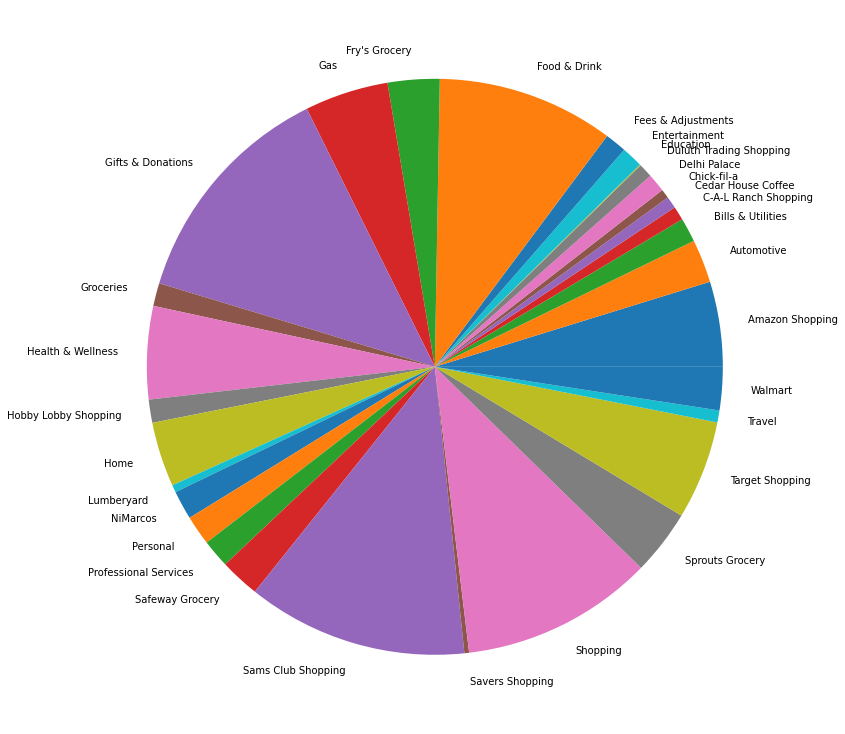

In [141]:
import matplotlib.pyplot as plt

cat_sums = chase_joined[chase_joined["include"]][["Category","Amount"]].groupby("Category").sum()
cat_sums.reset_index(inplace=True)
cat_sums["Amount"] = -1 * cat_sums["Amount"]
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
_ = ax.pie(cat_sums["Amount"].values, labels=cat_sums["Category"].values)
plt.show()


In [139]:
#chase_joined[(chase_joined["include"]) & (chase_joined["Category"]=="Shopping")].sort_values("Amount")
chase_joined[(chase_joined["include"]) & (chase_joined["Category"]=="Food & Drink")][["Description","Amount"]].groupby("Description").sum().sort_values("Amount", ascending=True)


,Amount
Description,
LA FONDA MEXICAN REST,-289.85
ELTAPATIO,-248.29
PATO THAI CUISINE,-200.81
NELLO S PIZZA MESA,-155.17
TST* UPTOWN PUBHOUSE,-142.58
SOSOBA,-141.52
ALL THE LUV WINGS 1300,-137.15
TST* TAVERNA MEDITERRANEA,-136.38
TST* MAMA BURGER2,-122.74


In [137]:
amazon_idxs = chase_joined[(chase_joined["include"]) & ((chase_joined["Description"].str.lower().str.contains("BEVERAGES &amp; MORE".lower())) | (chase_joined["Description"].str.lower().str.contains("BEVERAGES &amp; MORE".lower())))].index
chase_joined.loc[amazon_idxs, "Category"] = "Food & Drink"

In [80]:
sum_table = chase_joined[chase_joined["include"]][["Post Date","Amount"]].groupby(pd.Grouper(key='Post Date', freq='1M')).sum()
sum_table.loc["Average","Amount"] = sum_table["Amount"].mean()
sum_table


,Amount
Post Date,
2020-08-31 00:00:00,-3644.370
2020-09-30 00:00:00,-2985.300
2020-10-31 00:00:00,-3070.170
2020-11-30 00:00:00,-2406.730
2020-12-31 00:00:00,-1955.740
2021-01-31 00:00:00,-2874.370
2021-02-28 00:00:00,-5483.030
2021-03-31 00:00:00,-2206.840
2021-04-30 00:00:00,-2949.130


In [82]:
import math
from IPython.display import display

top_perc = 0.1
month_groups = chase_joined[chase_joined["include"]][["Post Date","Amount","Description"]].groupby(pd.Grouper(key='Post Date', freq='1M'))
for month_idx, month_group in month_groups:
    print()
    print(month_idx)
    sorted_month_group = month_group.sort_values("Amount", ascending=True)
    top_rows = sorted_month_group[0:max(1,math.floor(len(month_group) * top_perc))]
    display(top_rows)
    



2020-08-31 00:00:00


,Post Date,Amount,Description
3,2020-08-02,-316.90,SAMS CLUB #6604
30,2020-08-12,-223.92,SAMS CLUB #6604
39,2020-08-16,-185.00,RELATIONAL ADVANTAGE INC
76,2020-08-27,-185.00,RELATIONAL ADVANTAGE INC
31,2020-08-13,-156.45,TARGET.COM *
52,2020-08-19,-121.65,AMZN Mktp US*MM8D78HY1
71,2020-08-23,-119.00,WF* WAYFAIR 3388097486
53,2020-08-20,-108.39,SAMSCLUB #6604



2020-09-30 00:00:00


,Post Date,Amount,Description
134,2020-09-10,-235.10,SAMS CLUB #6219
161,2020-09-20,-195.53,SAMSCLUB #6604
163,2020-09-20,-185.00,RELATIONAL ADVANTAGE INC
185,2020-09-30,-141.50,SAMSCLUB #6604
135,2020-09-10,-107.85,MARSHALLS #0192
109,2020-09-04,-85.82,WOMENS CLINIC OF NORTHERN
100,2020-09-01,-85.49,SAMSCLUB #6604
122,2020-09-08,-77.96,DICKEYS AZ-1190



2020-10-31 00:00:00


,Post Date,Amount,Description
225,2020-10-14,-249.06,SAMS CLUB #6604
199,2020-10-04,-185.00,RELATIONAL ADVANTAGE INC
236,2020-10-18,-185.00,RELATIONAL ADVANTAGE INC
241,2020-10-21,-169.25,SAMS CLUB #6604
190,2020-10-01,-151.76,Amazon.com*M45SY0UQ0
272,2020-10-29,-121.01,BEVMO ECOMMERCE 998
268,2020-10-28,-106.52,UBAMBOOKS



2020-11-30 00:00:00


,Post Date,Amount,Description
292,2020-11-04,-316.59,SAMS CLUB #6604
335,2020-11-20,-185.66,SAMSCLUB #6604
295,2020-11-04,-185.00,RELATIONAL ADVANTAGE INC
296,2020-11-04,-182.28,WM SUPERCENTER #4252
287,2020-11-03,-157.08,SAMSCLUB.COM
277,2020-11-01,-77.08,Amazon.com*2871K8TI0



2020-12-31 00:00:00


,Post Date,Amount,Description
386,2020-12-16,-171.81,SAMS CLUB #6604
356,2020-12-08,-129.97,SAMS CLUB #6604
379,2020-12-15,-97.42,DT *DULUTH TRADING CO
372,2020-12-13,-76.42,AMZN Mktp US*9B67T8AE3
390,2020-12-17,-66.31,TARGET 00009357
402,2020-12-24,-62.86,GO AZ MOTORCYCLES - FLAGS



2021-01-31 00:00:00


,Post Date,Amount,Description
450,2021-01-12,-195.32,SAMSCLUB.COM
465,2021-01-18,-151.76,Amazon.com*PI6949KG3
478,2021-01-20,-149.48,THE HOME DEPOT 421
432,2021-01-05,-145.01,FLAGSTAFF MOTOR COMPANY
483,2021-01-24,-122.37,SAMS CLUB #6604
488,2021-01-24,-113.06,MICHAELS STORES 9608
477,2021-01-19,-104.69,SAMSCLUB #6604
495,2021-01-28,-88.97,WM SUPERCENTER #4252



2021-02-28 00:00:00


,Post Date,Amount,Description
538,2021-02-10,-2365.00,ACSTO
507,2021-02-01,-550.00,ANNUAL MEMBERSHIP FEE
542,2021-02-12,-185.00,RELATIONAL ADVANTAGE INC
545,2021-02-12,-109.01,SAMSCLUB #6604
521,2021-02-05,-105.98,SAMSCLUB.COM
578,2021-02-24,-97.91,SAMS CLUB #6604
532,2021-02-09,-87.99,DELHI PALACE
522,2021-02-07,-76.17,FRY'S FOOD DRG 104



2021-03-31 00:00:00


,Post Date,Amount,Description
661,2021-03-25,-199.76,SAMSCLUB #6604
623,2021-03-05,-185.00,RELATIONAL ADVANTAGE INC
607,2021-03-02,-185.00,RELATIONAL ADVANTAGE INC
667,2021-03-28,-143.72,SAMS CLUB #6604
665,2021-03-28,-111.92,MARSHALLS #1022
634,2021-03-08,-93.59,TST* BEAVER STREET BREWER
630,2021-03-07,-79.57,THE HOME DEPOT 421



2021-04-30 00:00:00


,Post Date,Amount,Description
724,2021-04-14,-600.00,SQ *WATSON CPA
770,2021-04-30,-129.93,Amazon Prime*6R5J42FV3
755,2021-04-23,-124.18,TARGET 00009357
746,2021-04-20,-120.00,PRESCOTT FRONTIER DAYS
748,2021-04-21,-101.04,TARGET 00009357
765,2021-04-27,-99.65,FRED MEYER 0655
691,2021-04-04,-95.16,SAMSCLUB #6604
729,2021-04-16,-92.20,SAMS CLUB #6604



2021-05-31 00:00:00


,Post Date,Amount,Description
854,2021-05-25,-250.15,SAMSCLUB #6604
804,2021-05-10,-248.79,SAMSCLUB #6604
828,2021-05-18,-147.75,WF WAYFAIR3575191976
812,2021-05-12,-139.17,DT *DULUTH TRADING CO
809,2021-05-12,-99.14,TARGET 00009357
826,2021-05-17,-94.89,ELTAPATIO
832,2021-05-19,-88.57,SPROUTS FARMERS MAR
837,2021-05-21,-85.88,THE HOME DEPOT 421
788,2021-05-06,-82.40,PP*DancEvolution



2021-06-30 00:00:00


,Post Date,Amount,Description
934,2021-06-20,-135.26,SONORA QUEST* LABS
900,2021-06-13,-128.69,SAMS CLUB #6604
875,2021-06-03,-119.12,SAMS CLUB #6604
954,2021-06-29,-112.21,SAMSCLUB #6604
882,2021-06-06,-102.40,WM SUPERCENTER #4252
940,2021-06-22,-98.77,CU* FLAGSTAFF MOPS
948,2021-06-27,-98.31,LA FONDA MEXICAN REST



2021-07-31 00:00:00


,Post Date,Amount,Description
1024,2021-07-28,-128.60,SQ *NORTHLAND EYE CARE
1010,2021-07-23,-103.63,SAMSCLUB #6604
965,2021-07-04,-99.29,TST* LUMBERYARD BREWING C
1022,2021-07-27,-92.79,SAMSCLUB #6604
1020,2021-07-26,-84.02,SPORTSMANS WAREHOUSE 239
994,2021-07-16,-72.53,FRY'S FOOD DRG 104
1019,2021-07-26,-71.46,TST* NIMARCO S PIZZA - 18



2021-08-31 00:00:00


,Post Date,Amount,Description
1089,2021-08-19,-600.00,IN *FLAGSTAFF COMMUNITY C
1053,2021-08-06,-142.36,SAMS CLUB #6604
1041,2021-08-01,-118.40,FLAGSTAFF MEDICAL CENTER
1052,2021-08-05,-95.52,SPROUTS FARMERS MAR
1058,2021-08-09,-94.84,TREVOR'S AT THE TRACKS
1088,2021-08-19,-90.35,AUTOZONE #2782
1119,2021-08-30,-86.60,THE HOME DEPOT 421



2021-09-30 00:00:00


,Post Date,Amount,Description
1170,2021-09-17,-172.60,SAMSCLUB.COM
1157,2021-09-13,-127.33,SAFEWAY #0270
1183,2021-09-21,-101.94,SAFEWAY #1225
1192,2021-09-26,-94.35,OREGANO'S ONLINE 1008
1130,2021-09-05,-65.86,ACI*FABRIC.COM
1151,2021-09-10,-65.50,DSW.
1162,2021-09-15,-63.27,SAMSCLUB #6604



2021-10-31 00:00:00


,Post Date,Amount,Description
1247,2021-10-17,-4515.75,IN *FLAGSTAFF COMMUNITY C
1265,2021-10-24,-909.02,FLAGSTAFF MOTOR COMPANY
1241,2021-10-13,-267.16,SAMS CLUB #6604
1212,2021-10-03,-199.54,SAMSCLUB #6604
1277,2021-10-28,-136.35,SAFEWAY #2028
1276,2021-10-27,-110.12,SPROUTS FARMERS MAR
1228,2021-10-10,-106.58,THREDUP



2021-11-30 00:00:00


,Post Date,Amount,Description
1304,2021-11-09,-184.42,SAMSCLUB #6604
1293,2021-11-07,-137.35,TST* LUMBERYARD BREWING C
1322,2021-11-17,-123.88,SAMSCLUB #6604
1337,2021-11-21,-114.53,SAMSCLUB #6604
1314,2021-11-15,-100.00,QT 1456
1312,2021-11-15,-100.00,QT 1456



2021-12-31 00:00:00


,Post Date,Amount,Description
1361,2021-12-02,-2435.00,ARIZONA TUITITION CONNECT
1359,2021-12-01,-155.27,SAMSCLUB #6604
1404,2021-12-14,-114.21,TARGET 00009357
1377,2021-12-06,-95.14,VIOLAS GARDEN
1458,2021-12-30,-93.98,THE HOME DEPOT 421
1405,2021-12-14,-82.75,TARGET 00009357
1365,2021-12-03,-77.24,GROVE
1409,2021-12-15,-76.43,N. ARIZONA BKST #1008
1459,2021-12-30,-66.31,WAL-MART #4252



2022-01-31 00:00:00


,Post Date,Amount,Description
1511,2022-01-20,-100.00,IN *FLAGSTAFF CLINIC OF N
1475,2022-01-06,-99.64,SAMSCLUB.COM
1538,2022-01-30,-96.31,PRINTEDMINT
1464,2022-01-03,-96.12,FRY'S FOOD DRG 104
1540,2022-01-30,-90.94,SAMS SCAN-N-GO
1498,2022-01-16,-71.92,TST* NiMarcos Pizza 1800
1473,2022-01-05,-68.68,EDDIEBAUER.COM
1535,2022-01-27,-62.49,ALL THE LUV WINGS 1300



2022-02-28 00:00:00


,Post Date,Amount,Description
1551,2022-02-01,-550.00,ANNUAL MEMBERSHIP FEE
1595,2022-02-13,-132.09,FRY'S FOOD DRG 104
1626,2022-02-20,-105.64,DILLARDS 908 CHANDLER
1593,2022-02-13,-93.96,TST* THAT PLACE PROJECTS
1554,2022-02-02,-93.75,SAMSCLUB #6604
1552,2022-02-01,-75.00,ANNUAL MEMBERSHIP FEE
1561,2022-02-04,-66.63,SPROUTS FARMERS MAR



2022-03-31 00:00:00


,Post Date,Amount,Description
1684,2022-03-13,-206.98,SAMSCLUB #6604
1728,2022-03-29,-202.31,SAMS SCAN-N-GO
1657,2022-03-04,-117.34,SAMSCLUB.COM
1695,2022-03-18,-100.11,SAMSCLUB #6604
1658,2022-03-04,-74.66,ALL THE LUV WINGS 1300
1722,2022-03-27,-74.64,LA FONDA MEXICAN REST
1703,2022-03-21,-72.70,HOBBY-LOBBY #483



2022-04-30 00:00:00


,Post Date,Amount,Description
1741,2022-04-05,-600.00,SQ *WATSON CPA
1798,2022-04-24,-127.73,SAMSCLUB #6604
1812,2022-04-28,-122.50,SAMSCLUB #6604
1791,2022-04-20,-110.00,REDEMPTION COUNSELING
1788,2022-04-19,-110.00,REDEMPTION COUNSELING
1809,2022-04-27,-110.00,REDEMPTION COUNSELING
1767,2022-04-12,-102.25,SAMSCLUB #6604



2022-05-31 00:00:00


,Post Date,Amount,Description
1895,2022-05-22,-407.97,SAMSCLUB #6604
1822,2022-05-01,-151.76,Amazon Prime*131023ZZ1
1894,2022-05-22,-128.81,TRACTOR SUPPLY CO #1807
1829,2022-05-04,-110.00,REDEMPTION COUNSELING
1883,2022-05-18,-110.00,REDEMPTION COUNSELING
1865,2022-05-13,-110.00,REDEMPTION COUNSELING
1841,2022-05-08,-92.11,FRY'S FOOD DRG 104
1839,2022-05-08,-87.30,1-800-FLOWERS.COM INC.
1884,2022-05-19,-84.16,TARGET 00009357



2022-06-30 00:00:00


,Post Date,Amount,Description
1929,2022-06-01,-110.00,REDEMPTION COUNSELING
2054,2022-06-27,-93.76,FRED M FUEL 9011 Q76
1980,2022-06-12,-93.52,TST* The Refuge - Hillsda
2066,2022-06-29,-93.10,SPROUTS FARMERS MAR
1926,2022-06-01,-87.33,AMZN Mktp US*1X6U48E00
1999,2022-06-17,-85.00,ARIZONA CORP COMM
1933,2022-06-02,-83.97,SAMS SCAN-N-GO
2042,2022-06-26,-83.82,FRED M FUEL 9011 Q76
2000,2022-06-17,-83.54,DELHI PALACE
1992,2022-06-15,-83.33,FLAGSTAFF MOTOR COMPANY



2022-07-31 00:00:00


,Post Date,Amount,Description
2108,2022-07-13,-165.59,SAMSCLUB #6604
2105,2022-07-13,-110.00,REDEMPTION COUNSELING
2084,2022-07-07,-110.00,REDEMPTION COUNSELING
2091,2022-07-10,-87.69,ELEPHANT ROCKS GOLF COURS


##### Save modified chase transactions

In [142]:

chase_joined.to_csv(join(fin_dir, "saved_modified_chase_transactions.csv"))


## Net Worth

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

with open("/Users/johnclark/Documents/Finances/networth.json") as f:
    rows = json.load(f)

net_worth = pd.DataFrame(rows)
net_worth["date"] = pd.to_datetime(net_worth["date"], format="%m/%d/%Y")
net_worth.set_index("date", drop=True, inplace=True)

nw_house_columns = ["Wells cash", "Wells credit", "chase credit", "wells brokerage", "fidelity", "etrade", "etrade stock","empower hannah", "empower john", "House value", "mortgage", "tithe"]
net_worth["total with house"] = net_worth[nw_house_columns].sum(axis=1)
nw_columns = ["Wells cash", "Wells credit", "chase credit", "wells brokerage", "fidelity", "etrade", "etrade stock","empower hannah", "empower john", "tithe"]
net_worth["total"] = net_worth[nw_columns].sum(axis=1)
net_worth["difference"] = 0.0
for row_idx in range(1,len(net_worth)):
    row_name = net_worth.iloc[row_idx].name
    net_worth.loc[row_name,"difference"] = net_worth.iloc[row_idx]["total"] - net_worth.iloc[row_idx-1]["total"]

display(net_worth)
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
_ = net_worth[nw_columns].plot(legend=True, figsize=(30,30), ax=ax1)
_ = net_worth[["total with house","total"]].plot(legend=True, figsize=(30,30), ax=ax2)
_ = net_worth["difference"].plot.bar(legend=True, figsize=(30,30), ax=ax3)
ax1.grid(color='gray', linewidth=1, axis='both', alpha=0.5)
ax2.grid(color='gray', linewidth=1, axis='both', alpha=0.5)
ax2.axvline(x=dt.date(2022,2,7), color='red', linestyle='-', label='biked 75K')
ax2.axvline(x=dt.date(2022,4,6), color='green', linestyle='-', label='taxes 58K')
ax2.axvline(x=dt.date(2022,2,23), color='purple', linestyle='-', label='alaska 13K')
ax2.axvline(x=dt.date(2022,6,29), color='blue', linestyle='-', label='alaska 12K')
ax2.legend()
ax3.grid(color='gray', linewidth=1, axis='both', alpha=0.5)



In [ ]:
75+58+13